In [13]:
import pandas as pd
import numpy as np

In [14]:
X = pd.read_csv('../data/USA/LC/X_train.csv.gz', compression='gzip', low_memory=False)
y = pd.read_csv('../data/USA/LC/y_train.csv')
y = y.loan_status_bin  #as series

In [15]:
X['grade']=X['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X['annual_inc_log'] = X['annual_inc'].apply(np.log)

In [16]:
used_vars = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from transformers import ColumnSelectTransformer, EncoderTransformer

cst = ColumnSelectTransformer(used_vars)
sce = EncoderTransformer()
sc = MinMaxScaler()
clf = LogisticRegression(penalty='l1', C=0.01, random_state=0, solver='liblinear')

pipe_lr = Pipeline([('colsel', cst), ('encoder', sce), ('scaler', sc), ('clf', clf)])

In [18]:
pipe_lr.fit(X, y)

Pipeline(memory=None,
     steps=[('colsel', ColumnSelectTransformer(col_names=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc_log', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal'...nalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [19]:
X_t = pd.read_csv('../data/USA/LC/X_test.csv')
y_t = pd.read_csv('../data/USA/LC/y_test.csv')
y_t = y_t.loan_status_bin  #as series

In [20]:
X_t['grade']=X_t['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X_t['annual_inc_log'] = X_t['annual_inc'].apply(np.log)

In [21]:
test_probas = pipe_lr.predict_proba(X_t)[:,1]

ROC-AUC-score:  0.7129020566821589


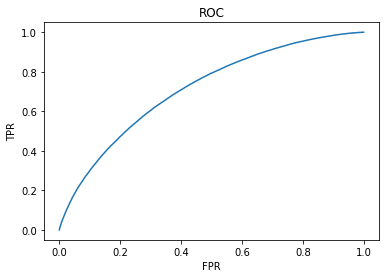

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, tresholds = roc_curve(y_t, test_probas)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_t, test_probas))

0.7129 original <br>
0.7107 original wout state data <br>
0.7084 wout american <br>
0.7062 wout american and state data <br>


In [23]:
tp = list(zip(pipe_lr.named_steps['encoder'].feature_Names, pipe_lr.named_steps['clf'].coef_[0]))
state_coef = sorted([(x[0][11:],x[1]) for x in tp if x[0][:10]=='addr_state'], key = lambda t: t[1], reverse=True)
state_coef

[('MS', 0.23679326565845768),
 ('LA', 0.2082991165993046),
 ('AR', 0.19508172566369564),
 ('OK', 0.17832785923800246),
 ('AL', 0.1620205166433522),
 ('NV', 0.09437833668670807),
 ('NY', 0.08291672938041537),
 ('MO', 0.07598179995001202),
 ('NJ', 0.07196270302474095),
 ('MD', 0.06182220563032374),
 ('FL', 0.06005873780235437),
 ('NE', 0.054162604637455515),
 ('IN', 0.0462673580598451),
 ('NC', 0.035769552962874505),
 ('TX', 0.03453875573784838),
 ('TN', 0.032433320529963824),
 ('NM', 0.01469528324350385),
 ('OH', 0.00842312985400238),
 ('PA', 0.004737015220169206),
 ('AK', 0.0),
 ('AZ', 0.0),
 ('DE', 0.0),
 ('HI', 0.0),
 ('IA', 0.0),
 ('ID', 0.0),
 ('KY', 0.0),
 ('MA', 0.0),
 ('ME', 0.0),
 ('MI', 0.0),
 ('MN', 0.0),
 ('MT', 0.0),
 ('ND', 0.0),
 ('RI', 0.0),
 ('SD', 0.0),
 ('VA', 0.0),
 ('VT', 0.0),
 ('WY', 0.0),
 ('CA', -0.02982152676910996),
 ('WI', -0.05210485875113093),
 ('GA', -0.07574281655714835),
 ('IL', -0.08264008785504187),
 ('UT', -0.09239051966183127),
 ('WV', -0.09559828801

In [24]:
import pickle
with open('../data/USA/LC/state_coef.pickle', 'wb') as b:
    pickle.dump(state_coef,b)